### BOGOMOL Neural Network

This notebook was created to test the conception of BOGOMOL Convolution Networks

Importing all needed libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW, lr_scheduler
from torchvision.transforms import v2
from datasets import load_dataset
from torchsummary import summary
from tqdm import tqdm
from src.models import ImageClassifier

Specifying CUDA if possible and setting multiprocessing start method to 'spawn', instead of 'fork', as it works better on UNIX-systems

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.multiprocessing.set_start_method('spawn', force=True)

Loading cifar10 dataset

In [ ]:
cifar_ds = load_dataset('uoft-cs/cifar10')
cifar_train = cifar_ds['train']
cifar_test = cifar_ds['test']
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Checking samples

0
airplane


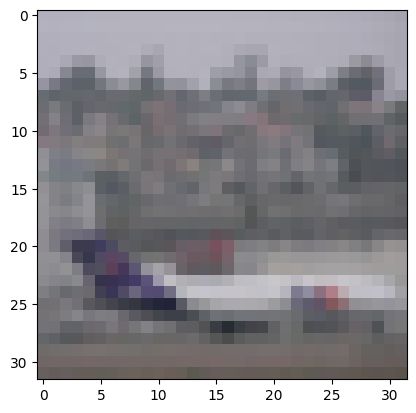

6
frog


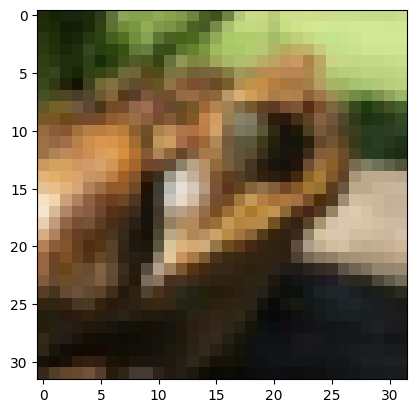

0
airplane


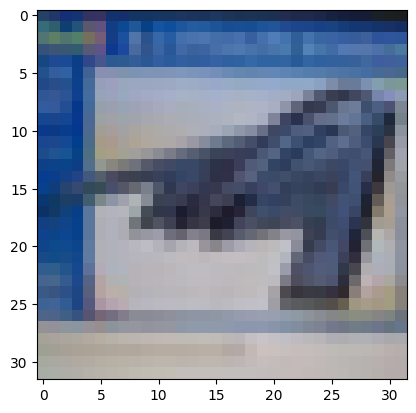

In [ ]:
for i in range(3):
    sample = cifar_train[i]
    image = sample['img']
    label = sample['label']
    print(label)
    fig, ax = plt.subplots()
    print(class_names[label])
    #print(np.array(image))
    ax.imshow(image)
    plt.show()

In [ ]:
transform_train = v2.Compose([
    v2.RandomCrop(32, padding=4),
    v2.RandomHorizontalFlip(),
    v2.RandAugment(num_ops=2, magnitude=9),
    v2.ToTensor(),
    v2.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2470, 0.2435, 0.2616]
    )
])

transform_test = v2.Compose([
    v2.ToTensor(),
    v2.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2470, 0.2435, 0.2616]
    )
])

/home/denis/Coding/projects/DiscreteNeuralNetworks/venv/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Creating cifar10 dataset

In [ ]:
class Cifar10Dataset(Dataset):
    def __init__(self, dataset : Dataset, transformation = None):
        super().__init__()
        self.dataset = dataset
        self.transformation = transformation

    def get_labeled(self, index : int):
        image, label = self.__getitem__(index)
        class_name = self.class_names[label]
        return image, class_name

    def __getitem__(self, index : int):
        sample = self.dataset[index]
        image = sample['img']
        if self.transformation is not None:
            image = self.transformation(image)
        image = np.array(image)
        label = sample['label']
        return image, label

    def __len__(self):
        return len(self.dataset)

In [ ]:
cifar_train_ds = Cifar10Dataset(cifar_train, transform_train)
cifar_test_ds = Cifar10Dataset(cifar_test, transform_test)

Creating simple dataloader

In [ ]:
cutmix = v2.CutMix(alpha=1.0, num_classes=len(class_names))
mixup = v2.MixUp(alpha=0.2, num_classes=len(class_names))
cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])

In [ ]:
BATCH_SIZE = 64

def collate_fn(batch):
    images = []
    labels = []
    for image, label in batch:
        image = torch.Tensor(image)
        images.append(image)
        labels.append(label)
    images = torch.stack(images, dim=0).float()
    labels = torch.Tensor(labels).long()
    return images, labels

def collate_fn_train(batch):
    return cutmix_or_mixup(collate_fn(batch))

cifar_train_dataloader = DataLoader(cifar_train_ds, collate_fn=collate_fn, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
cifar_test_dataloader = DataLoader(cifar_test_ds, collate_fn=collate_fn, batch_size=BATCH_SIZE, pin_memory=True)

Specifying loss

In [ ]:
loss_fn = nn.CrossEntropyLoss()

Specifying Image Classification model

In [ ]:
model = ImageClassifier((3, 32, 32), 32, len(class_names), 10, 2).to(device)

summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           2,432
    InstanceNorm2d-2           [-1, 32, 32, 32]               0
        SelfConv2d-3           [-1, 32, 32, 32]               0
              GELU-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]          25,632
    InstanceNorm2d-6           [-1, 32, 32, 32]               0
        SelfConv2d-7           [-1, 32, 32, 32]               0
              GELU-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]          25,632
   InstanceNorm2d-10           [-1, 32, 32, 32]               0
       SelfConv2d-11           [-1, 32, 32, 32]               0
             GELU-12           [-1, 32, 32, 32]               0
           Conv2d-13           [-1, 32, 32, 32]          25,632
   InstanceNorm2d-14           [-1, 32,

In [ ]:
history = {
    "train_loss" : [float('inf')],
    "train_acc" : [0],
    "test_loss" : [float('inf')],
    "test_acc" : [0]
}

In [ ]:
def compute_accuracy(predictions: torch.Tensor, ground_truth: torch.Tensor) -> float:
    """
    Вычисляет точность предсказаний модели на CIFAR-10.

    Аргументы:
        predictions (torch.Tensor): Логиты сети (без softmax), размер [batch_size, num_classes].
        ground_truth (torch.Tensor): Истинные метки, размер [batch_size].

    Возвращает:
        float: Значение точности (accuracy) в процентах.
    """
    predicted_classes = predictions.argmax(dim=1)
    correct = (predicted_classes == ground_truth).sum().item()
    accuracy = correct / ground_truth.size(0)
    return accuracy

In [ ]:
def train(model, dataloader, optimizer, scaler, coef : float = None, accumulation_steps : int = 4):
    model.train()
    pbar = tqdm(dataloader, f"Train loss: {history['train_loss'][-1]:.3f}, acc: {history['train_acc'][-1]:.3f}")
    total_loss = 0
    total_acc = 0
    out_of_mem = 0

    if coef is not None:
        coef = torch.tensor([coef]).to(device)
    # k = torch.tensor([1 + 10*math.exp(1 - math.sqrt(coef))]).to(device)
    # t = torch.tensor([coef/math.log(30 + coef)]).to(device)

    for batch_idx, (images, labels) in enumerate(pbar):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        try:
            with torch.autocast('cuda'):
                if coef is not None:
                    prediction = model(images, coef)
                else:
                    prediction = model(images)
                loss_value = loss_fn(prediction, labels)
            total_loss += loss_value.item()

            scaler.scale(loss_value/accumulation_steps).backward()

            with torch.no_grad():
                cur_acc = compute_accuracy(prediction, labels)
                total_acc += cur_acc

            if (batch_idx+1) % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            if batch_idx % 10 == 0:
                pbar.set_description(f"Train loss: {loss_value.item():.3f}, acc: {cur_acc:.3f}")
        except RuntimeError as e:
            if 'out of memory' in str(e):
                out_of_mem += 1
                torch.cuda.empty_cache()
            else:
                raise e
        del images, labels
    else:
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
    mean_loss = total_loss/(batch_idx + 1)
    history['train_loss'].append(mean_loss)
    mean_acc = total_acc/(batch_idx + 1)
    history['train_acc'].append(mean_acc)
    if out_of_mem:
        print(f"Memory overflow occurred in {out_of_mem}/{batch_idx+1} batches")
    return mean_loss, mean_acc

@torch.no_grad()
def test(model, dataloader):
    model.eval()
    pbar = tqdm(dataloader, f"Test loss: {history['test_loss'][-1]:.3f}")
    total_loss = 0
    total_acc = 0
    out_of_mem = 0
    for batch_idx, (images, labels) in enumerate(pbar):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        try:
            prediction = model(images)
            loss_value = loss_fn(prediction, labels)
            total_loss += loss_value.item()
            cur_acc = compute_accuracy(prediction, labels)
            total_acc += cur_acc
        except RuntimeError as e:
            if 'out of memory' in str(e):
                out_of_mem += 1
                torch.cuda.empty_cache()
            else:
                raise e
        if batch_idx % 10 == 0:
            pbar.set_description(f"Test loss: {loss_value.item():.3f}, acc: {cur_acc:.3f}")
        del images, labels

    mean_loss = total_loss/(batch_idx + 1)
    history['test_loss'].append(mean_loss)
    mean_acc = total_acc/(batch_idx + 1)
    history['test_acc'].append(mean_acc)
    if out_of_mem:
        print(f"Memory overflow occurred in {out_of_mem}/{batch_idx+1} batches")
    return mean_loss, mean_acc

In [ ]:
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

3116138


In [ ]:
EPOCHS = 150
optimizer = AdamW(model.parameters(), lr=3e-4, weight_decay=0.05)
scaler = torch.GradScaler(device)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS, eta_min=1e-6)

for i in range(EPOCHS):
    print(f"Training epoch: {i+1}/{EPOCHS}")
    # coef = 1 - (epoch//20*20)/(EPOCHS)
    # coef = 0.1 + epoch//20*0.2
    # coef = 1 + epoch//20*4
    train_loss, train_acc = train(model, cifar_train_dataloader, optimizer, scaler)
    print(f"Average training loss: {train_loss:.3f}, train accuracy: {train_acc:.3f}")
    print(f"Learning rate: {scheduler.get_last_lr()[0]}, gradient scale: {scaler.get_scale()}")
    scheduler.step()
    val_loss, val_acc = test(model, cifar_test_dataloader)
    print(f"Average test loss: {val_loss:.3f}, test accuracy: {val_acc:.3f}")
    print("-"*80)


Training epoch: 1/200


Train loss: 1.989, acc: 0.328: 100%|██████████| 782/782 [02:00<00:00,  6.51it/s]


Average training loss: 2.152, train accuracy: 0.195
Learning rate: 0.0003, gradient scale: 65536.0


Test loss: 2.196, acc: 0.328: 100%|██████████| 157/157 [00:08<00:00, 19.61it/s]


Average test loss: 1.987, test accuracy: 0.285
--------------------------------------------------------------------------------
Training epoch: 2/200


Train loss: 1.776, acc: 0.344: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 1.853, train accuracy: 0.316
Learning rate: 0.00029998155655600826, gradient scale: 65536.0


Test loss: 1.639, acc: 0.359: 100%|██████████| 157/157 [00:07<00:00, 19.64it/s]


Average test loss: 1.700, test accuracy: 0.373
--------------------------------------------------------------------------------
Training epoch: 3/200


Train loss: 1.611, acc: 0.406: 100%|██████████| 782/782 [01:55<00:00,  6.77it/s]


Average training loss: 1.701, train accuracy: 0.378
Learning rate: 0.0002999262307746769, gradient scale: 65536.0


Test loss: 1.589, acc: 0.359: 100%|██████████| 157/157 [00:08<00:00, 19.56it/s]


Average test loss: 1.529, test accuracy: 0.443
--------------------------------------------------------------------------------
Training epoch: 4/200


Train loss: 1.661, acc: 0.344: 100%|██████████| 782/782 [01:55<00:00,  6.77it/s]


Average training loss: 1.580, train accuracy: 0.423
Learning rate: 0.00029983403630681456, gradient scale: 65536.0


Test loss: 1.520, acc: 0.469: 100%|██████████| 157/157 [00:08<00:00, 19.60it/s]


Average test loss: 1.462, test accuracy: 0.478
--------------------------------------------------------------------------------
Training epoch: 5/200


Train loss: 1.161, acc: 0.594: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 1.476, train accuracy: 0.467
Learning rate: 0.00029970499590002665, gradient scale: 65536.0


Test loss: 1.345, acc: 0.609: 100%|██████████| 157/157 [00:07<00:00, 19.63it/s]


Average test loss: 1.328, test accuracy: 0.524
--------------------------------------------------------------------------------
Training epoch: 6/200


Train loss: 1.427, acc: 0.422: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 1.400, train accuracy: 0.497
Learning rate: 0.00029953914139310266, gradient scale: 65536.0


Test loss: 1.483, acc: 0.500: 100%|██████████| 157/157 [00:08<00:00, 19.62it/s]


Average test loss: 1.350, test accuracy: 0.524
--------------------------------------------------------------------------------
Training epoch: 7/200


Train loss: 1.343, acc: 0.516: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 1.319, train accuracy: 0.529
Learning rate: 0.00029933651370816046, gradient scale: 65536.0


Test loss: 1.393, acc: 0.547: 100%|██████████| 157/157 [00:08<00:00, 19.60it/s]


Average test loss: 1.300, test accuracy: 0.546
--------------------------------------------------------------------------------
Training epoch: 8/200


Train loss: 1.385, acc: 0.469: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 1.260, train accuracy: 0.554
Learning rate: 0.0002990971628405494, gradient scale: 65536.0


Test loss: 1.183, acc: 0.609: 100%|██████████| 157/157 [00:07<00:00, 19.63it/s]


Average test loss: 1.129, test accuracy: 0.603
--------------------------------------------------------------------------------
Training epoch: 9/200


Train loss: 0.933, acc: 0.703: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 1.202, train accuracy: 0.575
Learning rate: 0.00029882114784651444, gradient scale: 65536.0


Test loss: 1.037, acc: 0.609: 100%|██████████| 157/157 [00:08<00:00, 19.62it/s]


Average test loss: 1.066, test accuracy: 0.628
--------------------------------------------------------------------------------
Training epoch: 10/200


Train loss: 1.432, acc: 0.516: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 1.154, train accuracy: 0.590
Learning rate: 0.00029850853682862534, gradient scale: 65536.0


Test loss: 1.090, acc: 0.594: 100%|██████████| 157/157 [00:08<00:00, 19.61it/s]


Average test loss: 1.043, test accuracy: 0.635
--------------------------------------------------------------------------------
Training epoch: 11/200


Train loss: 0.914, acc: 0.734: 100%|██████████| 782/782 [01:55<00:00,  6.77it/s]


Average training loss: 1.115, train accuracy: 0.608
Learning rate: 0.0002981594069189731, gradient scale: 131072.0


Test loss: 0.960, acc: 0.625: 100%|██████████| 157/157 [00:08<00:00, 19.62it/s]


Average test loss: 1.013, test accuracy: 0.650
--------------------------------------------------------------------------------
Training epoch: 12/200


Train loss: 1.150, acc: 0.609: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 1.073, train accuracy: 0.620
Learning rate: 0.0002977738442601387, gradient scale: 131072.0


Test loss: 0.921, acc: 0.656: 100%|██████████| 157/157 [00:07<00:00, 19.64it/s]


Average test loss: 0.959, test accuracy: 0.668
--------------------------------------------------------------------------------
Training epoch: 13/200


Train loss: 0.968, acc: 0.625: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 1.047, train accuracy: 0.632
Learning rate: 0.000297351943983939, gradient scale: 131072.0


Test loss: 0.869, acc: 0.656: 100%|██████████| 157/157 [00:07<00:00, 19.66it/s]


Average test loss: 0.934, test accuracy: 0.678
--------------------------------------------------------------------------------
Training epoch: 14/200


Train loss: 1.202, acc: 0.578: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 1.018, train accuracy: 0.642
Learning rate: 0.000296893810187954, gradient scale: 131072.0


Test loss: 0.945, acc: 0.609: 100%|██████████| 157/157 [00:07<00:00, 19.64it/s]


Average test loss: 0.932, test accuracy: 0.677
--------------------------------------------------------------------------------
Training epoch: 15/200


Train loss: 1.023, acc: 0.656: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.996, train accuracy: 0.648
Learning rate: 0.00029639955590984277, gradient scale: 131072.0


Test loss: 0.879, acc: 0.703: 100%|██████████| 157/157 [00:08<00:00, 19.62it/s]


Average test loss: 0.897, test accuracy: 0.690
--------------------------------------------------------------------------------
Training epoch: 16/200


Train loss: 1.018, acc: 0.625: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.968, train accuracy: 0.659
Learning rate: 0.0002958693030994527, gradient scale: 131072.0


Test loss: 0.870, acc: 0.672: 100%|██████████| 157/157 [00:07<00:00, 19.66it/s]


Average test loss: 0.889, test accuracy: 0.690
--------------------------------------------------------------------------------
Training epoch: 17/200


Train loss: 0.932, acc: 0.719: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.957, train accuracy: 0.665
Learning rate: 0.0002953031825887304, gradient scale: 131072.0


Test loss: 0.895, acc: 0.656: 100%|██████████| 157/157 [00:08<00:00, 19.60it/s]


Average test loss: 0.929, test accuracy: 0.682
--------------------------------------------------------------------------------
Training epoch: 18/200


Train loss: 0.811, acc: 0.688: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.933, train accuracy: 0.671
Learning rate: 0.0002947013340594409, gradient scale: 131072.0


Test loss: 0.827, acc: 0.672: 100%|██████████| 157/157 [00:08<00:00, 19.61it/s]


Average test loss: 0.827, test accuracy: 0.710
--------------------------------------------------------------------------------
Training epoch: 19/200


Train loss: 0.993, acc: 0.672: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.907, train accuracy: 0.682
Learning rate: 0.00029406390600870307, gradient scale: 131072.0


Test loss: 0.898, acc: 0.688: 100%|██████████| 157/157 [00:08<00:00, 19.62it/s]


Average test loss: 0.829, test accuracy: 0.708
--------------------------------------------------------------------------------
Training epoch: 20/200


Train loss: 0.796, acc: 0.750: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.890, train accuracy: 0.687
Learning rate: 0.0002933910557123504, gradient scale: 131072.0


Test loss: 0.790, acc: 0.672: 100%|██████████| 157/157 [00:07<00:00, 19.65it/s]


Average test loss: 0.773, test accuracy: 0.730
--------------------------------------------------------------------------------
Training epoch: 21/200


Train loss: 1.107, acc: 0.641: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.884, train accuracy: 0.690
Learning rate: 0.00029268294918612553, gradient scale: 131072.0


Test loss: 0.813, acc: 0.688: 100%|██████████| 157/157 [00:07<00:00, 19.66it/s]


Average test loss: 0.768, test accuracy: 0.733
--------------------------------------------------------------------------------
Training epoch: 22/200


Train loss: 0.932, acc: 0.656: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.866, train accuracy: 0.697
Learning rate: 0.00029193976114471807, gradient scale: 131072.0


Test loss: 0.809, acc: 0.641: 100%|██████████| 157/157 [00:08<00:00, 19.61it/s]


Average test loss: 0.766, test accuracy: 0.733
--------------------------------------------------------------------------------
Training epoch: 23/200


Train loss: 0.989, acc: 0.656: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.855, train accuracy: 0.703
Learning rate: 0.00029116167495865674, gradient scale: 131072.0


Test loss: 0.667, acc: 0.719: 100%|██████████| 157/157 [00:08<00:00, 19.62it/s]


Average test loss: 0.799, test accuracy: 0.722
--------------------------------------------------------------------------------
Training epoch: 24/200


Train loss: 0.817, acc: 0.719: 100%|██████████| 782/782 [01:55<00:00,  6.77it/s]


Average training loss: 0.841, train accuracy: 0.707
Learning rate: 0.0002903488826090652, gradient scale: 131072.0


Test loss: 0.700, acc: 0.766: 100%|██████████| 157/157 [00:08<00:00, 19.61it/s]


Average test loss: 0.759, test accuracy: 0.734
--------------------------------------------------------------------------------
Training epoch: 25/200


Train loss: 0.656, acc: 0.734: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.823, train accuracy: 0.711
Learning rate: 0.0002895015846402936, gradient scale: 131072.0


Test loss: 0.772, acc: 0.688: 100%|██████████| 157/157 [00:08<00:00, 19.62it/s]


Average test loss: 0.797, test accuracy: 0.731
--------------------------------------------------------------------------------
Training epoch: 26/200


Train loss: 0.578, acc: 0.812: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.809, train accuracy: 0.715
Learning rate: 0.00028861999011043737, gradient scale: 131072.0


Test loss: 0.704, acc: 0.766: 100%|██████████| 157/157 [00:07<00:00, 19.64it/s]


Average test loss: 0.752, test accuracy: 0.737
--------------------------------------------------------------------------------
Training epoch: 27/200


Train loss: 0.809, acc: 0.734: 100%|██████████| 782/782 [01:55<00:00,  6.77it/s]


Average training loss: 0.805, train accuracy: 0.719
Learning rate: 0.00028770431653975514, gradient scale: 131072.0


Test loss: 0.691, acc: 0.812: 100%|██████████| 157/157 [00:07<00:00, 19.64it/s]


Average test loss: 0.753, test accuracy: 0.743
--------------------------------------------------------------------------------
Training epoch: 28/200


Train loss: 1.146, acc: 0.594: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.794, train accuracy: 0.724
Learning rate: 0.00028675478985699905, gradient scale: 131072.0


Test loss: 0.685, acc: 0.766: 100%|██████████| 157/157 [00:08<00:00, 19.57it/s]


Average test loss: 0.726, test accuracy: 0.745
--------------------------------------------------------------------------------
Training epoch: 29/200


Train loss: 0.710, acc: 0.734: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.788, train accuracy: 0.724
Learning rate: 0.00028577164434366993, gradient scale: 131072.0


Test loss: 0.684, acc: 0.734: 100%|██████████| 157/157 [00:07<00:00, 19.64it/s]


Average test loss: 0.700, test accuracy: 0.760
--------------------------------------------------------------------------------
Training epoch: 30/200


Train loss: 1.036, acc: 0.688: 100%|██████████| 782/782 [01:55<00:00,  6.77it/s]


Average training loss: 0.778, train accuracy: 0.730
Learning rate: 0.000284755122576212, gradient scale: 131072.0


Test loss: 0.716, acc: 0.734: 100%|██████████| 157/157 [00:08<00:00, 19.62it/s]


Average test loss: 0.740, test accuracy: 0.744
--------------------------------------------------------------------------------
Training epoch: 31/200


Train loss: 0.813, acc: 0.703: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.764, train accuracy: 0.731
Learning rate: 0.00028370547536616097, gradient scale: 131072.0


Test loss: 0.678, acc: 0.766: 100%|██████████| 157/157 [00:08<00:00, 19.60it/s]


Average test loss: 0.698, test accuracy: 0.756
--------------------------------------------------------------------------------
Training epoch: 32/200


Train loss: 0.548, acc: 0.797: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.757, train accuracy: 0.735
Learning rate: 0.00028262296169825966, gradient scale: 131072.0


Test loss: 0.572, acc: 0.750: 100%|██████████| 157/157 [00:08<00:00, 19.60it/s]


Average test loss: 0.691, test accuracy: 0.759
--------------------------------------------------------------------------------
Training epoch: 33/200


Train loss: 0.840, acc: 0.688: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.741, train accuracy: 0.743
Learning rate: 0.00028150784866655756, gradient scale: 131072.0


Test loss: 0.663, acc: 0.734: 100%|██████████| 157/157 [00:07<00:00, 19.63it/s]


Average test loss: 0.679, test accuracy: 0.762
--------------------------------------------------------------------------------
Training epoch: 34/200


Train loss: 0.615, acc: 0.797: 100%|██████████| 782/782 [01:55<00:00,  6.77it/s]


Average training loss: 0.734, train accuracy: 0.743
Learning rate: 0.0002803604114085096, gradient scale: 131072.0


Test loss: 0.665, acc: 0.766: 100%|██████████| 157/157 [00:08<00:00, 19.61it/s]


Average test loss: 0.693, test accuracy: 0.760
--------------------------------------------------------------------------------
Training epoch: 35/200


Train loss: 0.697, acc: 0.750: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.724, train accuracy: 0.747
Learning rate: 0.00027918093303708956, gradient scale: 131072.0


Test loss: 0.541, acc: 0.828: 100%|██████████| 157/157 [00:07<00:00, 19.67it/s]


Average test loss: 0.652, test accuracy: 0.776
--------------------------------------------------------------------------------
Training epoch: 36/200


Train loss: 0.466, acc: 0.844: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.720, train accuracy: 0.749
Learning rate: 0.0002779697045709368, gradient scale: 131072.0


Test loss: 0.620, acc: 0.766: 100%|██████████| 157/157 [00:07<00:00, 19.66it/s]


Average test loss: 0.661, test accuracy: 0.769
--------------------------------------------------------------------------------
Training epoch: 37/200


Train loss: 0.744, acc: 0.766: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.709, train accuracy: 0.751
Learning rate: 0.00027672702486255125, gradient scale: 131072.0


Test loss: 0.710, acc: 0.766: 100%|██████████| 157/157 [00:08<00:00, 19.58it/s]


Average test loss: 0.687, test accuracy: 0.763
--------------------------------------------------------------------------------
Training epoch: 38/200


Train loss: 0.675, acc: 0.766: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.705, train accuracy: 0.754
Learning rate: 0.0002754532005245564, gradient scale: 131072.0


Test loss: 0.640, acc: 0.750: 100%|██████████| 157/157 [00:08<00:00, 19.61it/s]


Average test loss: 0.654, test accuracy: 0.774
--------------------------------------------------------------------------------
Training epoch: 39/200


Train loss: 0.573, acc: 0.797: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.700, train accuracy: 0.756
Learning rate: 0.00027414854585404696, gradient scale: 131072.0


Test loss: 0.608, acc: 0.766: 100%|██████████| 157/157 [00:08<00:00, 19.59it/s]


Average test loss: 0.692, test accuracy: 0.765
--------------------------------------------------------------------------------
Training epoch: 40/200


Train loss: 0.666, acc: 0.750: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.699, train accuracy: 0.755
Learning rate: 0.000272813382755041, gradient scale: 131072.0


Test loss: 0.619, acc: 0.719: 100%|██████████| 157/157 [00:07<00:00, 19.66it/s]


Average test loss: 0.678, test accuracy: 0.768
--------------------------------------------------------------------------------
Training epoch: 41/200


Train loss: 0.782, acc: 0.797: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.686, train accuracy: 0.762
Learning rate: 0.00027144804065905466, gradient scale: 131072.0


Test loss: 0.533, acc: 0.750: 100%|██████████| 157/157 [00:08<00:00, 19.61it/s]


Average test loss: 0.647, test accuracy: 0.776
--------------------------------------------------------------------------------
Training epoch: 42/200


Train loss: 0.668, acc: 0.719: 100%|██████████| 782/782 [01:55<00:00,  6.77it/s]


Average training loss: 0.685, train accuracy: 0.761
Learning rate: 0.00027005285644382006, gradient scale: 131072.0


Test loss: 0.588, acc: 0.797: 100%|██████████| 157/157 [00:07<00:00, 19.65it/s]


Average test loss: 0.643, test accuracy: 0.781
--------------------------------------------------------------------------------
Training epoch: 43/200


Train loss: 0.878, acc: 0.703: 100%|██████████| 782/782 [01:55<00:00,  6.77it/s]


Average training loss: 0.673, train accuracy: 0.764
Learning rate: 0.0002686281743501657, gradient scale: 131072.0


Test loss: 0.682, acc: 0.766: 100%|██████████| 157/157 [00:07<00:00, 19.65it/s]


Average test loss: 0.665, test accuracy: 0.773
--------------------------------------------------------------------------------
Training epoch: 44/200


Train loss: 0.566, acc: 0.766: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.668, train accuracy: 0.765
Learning rate: 0.0002671743458970803, gradient scale: 65536.0


Test loss: 0.643, acc: 0.719: 100%|██████████| 157/157 [00:07<00:00, 19.63it/s]


Average test loss: 0.614, test accuracy: 0.786
--------------------------------------------------------------------------------
Training epoch: 45/200


Train loss: 0.695, acc: 0.688: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.662, train accuracy: 0.768
Learning rate: 0.0002656917297949805, gradient scale: 65536.0


Test loss: 0.671, acc: 0.781: 100%|██████████| 157/157 [00:08<00:00, 19.60it/s]


Average test loss: 0.636, test accuracy: 0.780
--------------------------------------------------------------------------------
Training epoch: 46/200


Train loss: 0.628, acc: 0.781: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.656, train accuracy: 0.772
Learning rate: 0.00026418069185720465, gradient scale: 65536.0


Test loss: 0.599, acc: 0.766: 100%|██████████| 157/157 [00:08<00:00, 19.62it/s]


Average test loss: 0.617, test accuracy: 0.790
--------------------------------------------------------------------------------
Training epoch: 47/200


Train loss: 0.639, acc: 0.750: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.655, train accuracy: 0.771
Learning rate: 0.0002626416049097537, gradient scale: 65536.0


Test loss: 0.600, acc: 0.797: 100%|██████████| 157/157 [00:08<00:00, 19.59it/s]


Average test loss: 0.613, test accuracy: 0.790
--------------------------------------------------------------------------------
Training epoch: 48/200


Train loss: 0.808, acc: 0.703: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.647, train accuracy: 0.773
Learning rate: 0.0002610748486993021, gradient scale: 65536.0


Test loss: 0.664, acc: 0.750: 100%|██████████| 157/157 [00:08<00:00, 19.62it/s]


Average test loss: 0.639, test accuracy: 0.783
--------------------------------------------------------------------------------
Training epoch: 49/200


Train loss: 0.687, acc: 0.703: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.640, train accuracy: 0.777
Learning rate: 0.000259480809799501, gradient scale: 65536.0


Test loss: 0.555, acc: 0.766: 100%|██████████| 157/157 [00:08<00:00, 19.62it/s]


Average test loss: 0.599, test accuracy: 0.796
--------------------------------------------------------------------------------
Training epoch: 50/200


Train loss: 0.663, acc: 0.734: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.634, train accuracy: 0.779
Learning rate: 0.00025785988151559667, gradient scale: 65536.0


Test loss: 0.593, acc: 0.797: 100%|██████████| 157/157 [00:07<00:00, 19.65it/s]


Average test loss: 0.631, test accuracy: 0.785
--------------------------------------------------------------------------------
Training epoch: 51/200


Train loss: 0.667, acc: 0.781: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.627, train accuracy: 0.780
Learning rate: 0.0002562124637873888, gradient scale: 65536.0


Test loss: 0.486, acc: 0.812: 100%|██████████| 157/157 [00:07<00:00, 19.65it/s]


Average test loss: 0.625, test accuracy: 0.790
--------------------------------------------------------------------------------
Training epoch: 52/200


Train loss: 0.718, acc: 0.781: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.626, train accuracy: 0.783
Learning rate: 0.0002545389630905509, gradient scale: 65536.0


Test loss: 0.509, acc: 0.781: 100%|██████████| 157/157 [00:07<00:00, 19.64it/s]


Average test loss: 0.609, test accuracy: 0.794
--------------------------------------------------------------------------------
Training epoch: 53/200


Train loss: 0.539, acc: 0.859: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.620, train accuracy: 0.784
Learning rate: 0.0002528397923363389, gradient scale: 65536.0


Test loss: 0.464, acc: 0.812: 100%|██████████| 157/157 [00:08<00:00, 19.62it/s]


Average test loss: 0.593, test accuracy: 0.796
--------------------------------------------------------------------------------
Training epoch: 54/200


Train loss: 0.598, acc: 0.766: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.615, train accuracy: 0.786
Learning rate: 0.000251115370769711, gradient scale: 131072.0


Test loss: 0.528, acc: 0.812: 100%|██████████| 157/157 [00:07<00:00, 19.65it/s]


Average test loss: 0.600, test accuracy: 0.795
--------------------------------------------------------------------------------
Training epoch: 55/200


Train loss: 0.513, acc: 0.828: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.606, train accuracy: 0.789
Learning rate: 0.0002493661238658858, gradient scale: 131072.0


Test loss: 0.489, acc: 0.797: 100%|██████████| 157/157 [00:07<00:00, 19.63it/s]


Average test loss: 0.593, test accuracy: 0.796
--------------------------------------------------------------------------------
Training epoch: 56/200


Train loss: 0.544, acc: 0.828: 100%|██████████| 782/782 [01:55<00:00,  6.77it/s]


Average training loss: 0.608, train accuracy: 0.787
Learning rate: 0.0002475924832253623, gradient scale: 131072.0


Test loss: 0.438, acc: 0.844: 100%|██████████| 157/157 [00:07<00:00, 19.63it/s]


Average test loss: 0.578, test accuracy: 0.803
--------------------------------------------------------------------------------
Training epoch: 57/200


Train loss: 0.650, acc: 0.828: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.605, train accuracy: 0.789
Learning rate: 0.000245794886467429, gradient scale: 131072.0


Test loss: 0.560, acc: 0.781: 100%|██████████| 157/157 [00:07<00:00, 19.63it/s]


Average test loss: 0.578, test accuracy: 0.806
--------------------------------------------------------------------------------
Training epoch: 58/200


Train loss: 0.566, acc: 0.797: 100%|██████████| 782/782 [01:55<00:00,  6.77it/s]


Average training loss: 0.590, train accuracy: 0.795
Learning rate: 0.0002439737771221878, gradient scale: 131072.0


Test loss: 0.563, acc: 0.766: 100%|██████████| 157/157 [00:08<00:00, 19.61it/s]


Average test loss: 0.571, test accuracy: 0.805
--------------------------------------------------------------------------------
Training epoch: 59/200


Train loss: 0.664, acc: 0.781: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.589, train accuracy: 0.793
Learning rate: 0.00024212960452111987, gradient scale: 131072.0


Test loss: 0.586, acc: 0.781: 100%|██████████| 157/157 [00:07<00:00, 19.65it/s]


Average test loss: 0.575, test accuracy: 0.803
--------------------------------------------------------------------------------
Training epoch: 60/200


Train loss: 0.551, acc: 0.828: 100%|██████████| 782/782 [01:55<00:00,  6.79it/s]


Average training loss: 0.585, train accuracy: 0.795
Learning rate: 0.00024026282368621956, gradient scale: 131072.0


Test loss: 0.530, acc: 0.828: 100%|██████████| 157/157 [00:08<00:00, 19.62it/s]


Average test loss: 0.603, test accuracy: 0.796
--------------------------------------------------------------------------------
Training epoch: 61/200


Train loss: 0.701, acc: 0.766: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.578, train accuracy: 0.797
Learning rate: 0.00023837389521772463, gradient scale: 131072.0


Test loss: 0.608, acc: 0.797: 100%|██████████| 157/157 [00:08<00:00, 19.62it/s]


Average test loss: 0.576, test accuracy: 0.801
--------------------------------------------------------------------------------
Training epoch: 62/200


Train loss: 0.381, acc: 0.859: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.577, train accuracy: 0.799
Learning rate: 0.00023646328518047002, gradient scale: 131072.0


Test loss: 0.472, acc: 0.812: 100%|██████████| 157/157 [00:07<00:00, 19.65it/s]


Average test loss: 0.568, test accuracy: 0.808
--------------------------------------------------------------------------------
Training epoch: 63/200


Train loss: 0.653, acc: 0.734: 100%|██████████| 782/782 [01:55<00:00,  6.77it/s]


Average training loss: 0.573, train accuracy: 0.800
Learning rate: 0.00023453146498889343, gradient scale: 131072.0


Test loss: 0.490, acc: 0.781: 100%|██████████| 157/157 [00:08<00:00, 19.61it/s]


Average test loss: 0.575, test accuracy: 0.804
--------------------------------------------------------------------------------
Training epoch: 64/200


Train loss: 0.675, acc: 0.766: 100%|██████████| 782/782 [01:55<00:00,  6.77it/s]


Average training loss: 0.562, train accuracy: 0.803
Learning rate: 0.00023257891129072056, gradient scale: 131072.0


Test loss: 0.547, acc: 0.797: 100%|██████████| 157/157 [00:08<00:00, 19.61it/s]


Average test loss: 0.572, test accuracy: 0.804
--------------------------------------------------------------------------------
Training epoch: 65/200


Train loss: 0.430, acc: 0.844: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.564, train accuracy: 0.804
Learning rate: 0.00023060610584935983, gradient scale: 131072.0


Test loss: 0.547, acc: 0.797: 100%|██████████| 157/157 [00:08<00:00, 19.62it/s]


Average test loss: 0.589, test accuracy: 0.799
--------------------------------------------------------------------------------
Training epoch: 66/200


Train loss: 0.467, acc: 0.859: 100%|██████████| 782/782 [01:55<00:00,  6.77it/s]


Average training loss: 0.562, train accuracy: 0.803
Learning rate: 0.00022861353542503419, gradient scale: 131072.0


Test loss: 0.499, acc: 0.828: 100%|██████████| 157/157 [00:08<00:00, 19.58it/s]


Average test loss: 0.590, test accuracy: 0.798
--------------------------------------------------------------------------------
Training epoch: 67/200


Train loss: 0.573, acc: 0.828: 100%|██████████| 782/782 [01:55<00:00,  6.77it/s]


Average training loss: 0.562, train accuracy: 0.804
Learning rate: 0.00022660169165468036, gradient scale: 131072.0


Test loss: 0.455, acc: 0.844: 100%|██████████| 157/157 [00:08<00:00, 19.61it/s]


Average test loss: 0.583, test accuracy: 0.805
--------------------------------------------------------------------------------
Training epoch: 68/200


Train loss: 0.660, acc: 0.719: 100%|██████████| 782/782 [01:55<00:00,  6.77it/s]


Average training loss: 0.548, train accuracy: 0.808
Learning rate: 0.00022457107093064478, gradient scale: 131072.0


Test loss: 0.544, acc: 0.797: 100%|██████████| 157/157 [00:08<00:00, 19.62it/s]


Average test loss: 0.582, test accuracy: 0.806
--------------------------------------------------------------------------------
Training epoch: 69/200


Train loss: 0.419, acc: 0.844: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.548, train accuracy: 0.808
Learning rate: 0.00022252217427820627, gradient scale: 131072.0


Test loss: 0.496, acc: 0.797: 100%|██████████| 157/157 [00:07<00:00, 19.65it/s]


Average test loss: 0.560, test accuracy: 0.808
--------------------------------------------------------------------------------
Training epoch: 70/200


Train loss: 0.604, acc: 0.750: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.540, train accuracy: 0.812
Learning rate: 0.0002204555072319556, gradient scale: 131072.0


Test loss: 0.519, acc: 0.766: 100%|██████████| 157/157 [00:07<00:00, 19.65it/s]


Average test loss: 0.541, test accuracy: 0.816
--------------------------------------------------------------------------------
Training epoch: 71/200


Train loss: 0.555, acc: 0.812: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.541, train accuracy: 0.812
Learning rate: 0.0002183715797110621, gradient scale: 131072.0


Test loss: 0.548, acc: 0.797: 100%|██████████| 157/157 [00:07<00:00, 19.63it/s]


Average test loss: 0.571, test accuracy: 0.804
--------------------------------------------------------------------------------
Training epoch: 72/200


Train loss: 0.484, acc: 0.844: 100%|██████████| 782/782 [01:55<00:00,  6.77it/s]


Average training loss: 0.537, train accuracy: 0.813
Learning rate: 0.00021627090589345917, gradient scale: 131072.0


Test loss: 0.604, acc: 0.766: 100%|██████████| 157/157 [00:07<00:00, 19.65it/s]


Average test loss: 0.561, test accuracy: 0.813
--------------------------------------------------------------------------------
Training epoch: 73/200


Train loss: 0.616, acc: 0.781: 100%|██████████| 782/782 [01:55<00:00,  6.77it/s]


Average training loss: 0.535, train accuracy: 0.814
Learning rate: 0.00021415400408897824, gradient scale: 131072.0


Test loss: 0.557, acc: 0.734: 100%|██████████| 157/157 [00:08<00:00, 19.62it/s]


Average test loss: 0.544, test accuracy: 0.817
--------------------------------------------------------------------------------
Training epoch: 74/200


Train loss: 0.603, acc: 0.734: 100%|██████████| 782/782 [01:55<00:00,  6.77it/s]


Average training loss: 0.530, train accuracy: 0.815
Learning rate: 0.00021202139661146365, gradient scale: 131072.0


Test loss: 0.514, acc: 0.828: 100%|██████████| 157/157 [00:07<00:00, 19.64it/s]


Average test loss: 0.572, test accuracy: 0.804
--------------------------------------------------------------------------------
Training epoch: 75/200


Train loss: 0.644, acc: 0.812: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.523, train accuracy: 0.817
Learning rate: 0.00020987360964989956, gradient scale: 131072.0


Test loss: 0.553, acc: 0.797: 100%|██████████| 157/157 [00:08<00:00, 19.62it/s]


Average test loss: 0.559, test accuracy: 0.813
--------------------------------------------------------------------------------
Training epoch: 76/200


Train loss: 0.539, acc: 0.797: 100%|██████████| 782/782 [01:55<00:00,  6.77it/s]


Average training loss: 0.520, train accuracy: 0.819
Learning rate: 0.0002077111731385808, gradient scale: 131072.0


Test loss: 0.458, acc: 0.812: 100%|██████████| 157/157 [00:08<00:00, 19.61it/s]


Average test loss: 0.549, test accuracy: 0.815
--------------------------------------------------------------------------------
Training epoch: 77/200


Train loss: 0.476, acc: 0.812: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.513, train accuracy: 0.819
Learning rate: 0.00020553462062635925, gradient scale: 131072.0


Test loss: 0.533, acc: 0.797: 100%|██████████| 157/157 [00:08<00:00, 19.61it/s]


Average test loss: 0.563, test accuracy: 0.811
--------------------------------------------------------------------------------
Training epoch: 78/200


Train loss: 0.596, acc: 0.844: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.513, train accuracy: 0.818
Learning rate: 0.0002033444891449988, gradient scale: 131072.0


Test loss: 0.516, acc: 0.828: 100%|██████████| 157/157 [00:07<00:00, 19.64it/s]


Average test loss: 0.561, test accuracy: 0.811
--------------------------------------------------------------------------------
Training epoch: 79/200


Train loss: 0.545, acc: 0.859: 100%|██████████| 782/782 [01:55<00:00,  6.77it/s]


Average training loss: 0.511, train accuracy: 0.820
Learning rate: 0.00020114131907667096, gradient scale: 131072.0


Test loss: 0.464, acc: 0.828: 100%|██████████| 157/157 [00:07<00:00, 19.65it/s]


Average test loss: 0.550, test accuracy: 0.812
--------------------------------------------------------------------------------
Training epoch: 80/200


Train loss: 0.696, acc: 0.781: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.505, train accuracy: 0.821
Learning rate: 0.00019892565402062322, gradient scale: 131072.0


Test loss: 0.492, acc: 0.766: 100%|██████████| 157/157 [00:07<00:00, 19.67it/s]


Average test loss: 0.550, test accuracy: 0.815
--------------------------------------------------------------------------------
Training epoch: 81/200


Train loss: 0.322, acc: 0.922: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.504, train accuracy: 0.823
Learning rate: 0.00019669804065905453, gradient scale: 131072.0


Test loss: 0.572, acc: 0.781: 100%|██████████| 157/157 [00:08<00:00, 19.60it/s]


Average test loss: 0.530, test accuracy: 0.820
--------------------------------------------------------------------------------
Training epoch: 82/200


Train loss: 0.500, acc: 0.828: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.494, train accuracy: 0.827
Learning rate: 0.00019445902862222933, gradient scale: 131072.0


Test loss: 0.502, acc: 0.812: 100%|██████████| 157/157 [00:08<00:00, 19.61it/s]


Average test loss: 0.566, test accuracy: 0.811
--------------------------------------------------------------------------------
Training epoch: 83/200


Train loss: 0.275, acc: 0.906: 100%|██████████| 782/782 [01:55<00:00,  6.77it/s]


Average training loss: 0.500, train accuracy: 0.825
Learning rate: 0.00019220917035286467, gradient scale: 131072.0


Test loss: 0.479, acc: 0.797: 100%|██████████| 157/157 [00:07<00:00, 19.65it/s]


Average test loss: 0.542, test accuracy: 0.816
--------------------------------------------------------------------------------
Training epoch: 84/200


Train loss: 0.376, acc: 0.891: 100%|██████████| 782/782 [01:55<00:00,  6.77it/s]


Average training loss: 0.495, train accuracy: 0.824
Learning rate: 0.0001899490209698231, gradient scale: 131072.0


Test loss: 0.534, acc: 0.781: 100%|██████████| 157/157 [00:07<00:00, 19.63it/s]


Average test loss: 0.545, test accuracy: 0.817
--------------------------------------------------------------------------------
Training epoch: 85/200


Train loss: 0.479, acc: 0.812: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.491, train accuracy: 0.827
Learning rate: 0.00018767913813114563, gradient scale: 131072.0


Test loss: 0.486, acc: 0.859: 100%|██████████| 157/157 [00:07<00:00, 19.64it/s]


Average test loss: 0.545, test accuracy: 0.821
--------------------------------------------------------------------------------
Training epoch: 86/200


Train loss: 0.555, acc: 0.781: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.485, train accuracy: 0.830
Learning rate: 0.00018540008189645775, gradient scale: 131072.0


Test loss: 0.556, acc: 0.781: 100%|██████████| 157/157 [00:07<00:00, 19.64it/s]


Average test loss: 0.544, test accuracy: 0.819
--------------------------------------------------------------------------------
Training epoch: 87/200


Train loss: 0.399, acc: 0.875: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.483, train accuracy: 0.829
Learning rate: 0.00018311241458878301, gradient scale: 131072.0


Test loss: 0.521, acc: 0.812: 100%|██████████| 157/157 [00:08<00:00, 19.62it/s]


Average test loss: 0.527, test accuracy: 0.820
--------------------------------------------------------------------------------
Training epoch: 88/200


Train loss: 0.500, acc: 0.797: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.482, train accuracy: 0.832
Learning rate: 0.00018081670065579853, gradient scale: 131072.0


Test loss: 0.589, acc: 0.797: 100%|██████████| 157/157 [00:07<00:00, 19.64it/s]


Average test loss: 0.540, test accuracy: 0.819
--------------------------------------------------------------------------------
Training epoch: 89/200


Train loss: 0.802, acc: 0.719: 100%|██████████| 782/782 [01:55<00:00,  6.77it/s]


Average training loss: 0.478, train accuracy: 0.834
Learning rate: 0.00017851350653056575, gradient scale: 131072.0


Test loss: 0.573, acc: 0.766: 100%|██████████| 157/157 [00:07<00:00, 19.64it/s]


Average test loss: 0.540, test accuracy: 0.822
--------------------------------------------------------------------------------
Training epoch: 90/200


Train loss: 0.393, acc: 0.844: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.471, train accuracy: 0.836
Learning rate: 0.0001762034004917716, gradient scale: 131072.0


Test loss: 0.544, acc: 0.781: 100%|██████████| 157/157 [00:08<00:00, 19.61it/s]


Average test loss: 0.529, test accuracy: 0.823
--------------------------------------------------------------------------------
Training epoch: 91/200


Train loss: 0.460, acc: 0.875: 100%|██████████| 782/782 [01:55<00:00,  6.77it/s]


Average training loss: 0.473, train accuracy: 0.835
Learning rate: 0.0001738869525235144, gradient scale: 65536.0


Test loss: 0.472, acc: 0.828: 100%|██████████| 157/157 [00:07<00:00, 19.63it/s]


Average test loss: 0.534, test accuracy: 0.823
--------------------------------------------------------------------------------
Training epoch: 92/200


Train loss: 0.298, acc: 0.859: 100%|██████████| 782/782 [01:55<00:00,  6.77it/s]


Average training loss: 0.468, train accuracy: 0.837
Learning rate: 0.00017156473417466851, gradient scale: 65536.0


Test loss: 0.504, acc: 0.828: 100%|██████████| 157/157 [00:08<00:00, 19.62it/s]


Average test loss: 0.527, test accuracy: 0.825
--------------------------------------------------------------------------------
Training epoch: 93/200


Train loss: 0.384, acc: 0.859: 100%|██████████| 782/782 [01:55<00:00,  6.77it/s]


Average training loss: 0.459, train accuracy: 0.840
Learning rate: 0.0001692373184178634, gradient scale: 65536.0


Test loss: 0.568, acc: 0.812: 100%|██████████| 157/157 [00:08<00:00, 19.56it/s]


Average test loss: 0.515, test accuracy: 0.826
--------------------------------------------------------------------------------
Training epoch: 94/200


Train loss: 0.454, acc: 0.844: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.461, train accuracy: 0.839
Learning rate: 0.00016690527950811117, gradient scale: 65536.0


Test loss: 0.555, acc: 0.797: 100%|██████████| 157/157 [00:08<00:00, 19.62it/s]


Average test loss: 0.530, test accuracy: 0.825
--------------------------------------------------------------------------------
Training epoch: 95/200


Train loss: 0.333, acc: 0.891: 100%|██████████| 782/782 [01:55<00:00,  6.77it/s]


Average training loss: 0.459, train accuracy: 0.841
Learning rate: 0.0001645691928411178, gradient scale: 65536.0


Test loss: 0.554, acc: 0.797: 100%|██████████| 157/157 [00:08<00:00, 19.60it/s]


Average test loss: 0.527, test accuracy: 0.822
--------------------------------------------------------------------------------
Training epoch: 96/200


Train loss: 0.276, acc: 0.906: 100%|██████████| 782/782 [01:55<00:00,  6.77it/s]


Average training loss: 0.460, train accuracy: 0.838
Learning rate: 0.00016222963481131274, gradient scale: 65536.0


Test loss: 0.592, acc: 0.797: 100%|██████████| 157/157 [00:08<00:00, 19.61it/s]


Average test loss: 0.515, test accuracy: 0.828
--------------------------------------------------------------------------------
Training epoch: 97/200


Train loss: 0.349, acc: 0.844: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.446, train accuracy: 0.844
Learning rate: 0.00015988718266963226, gradient scale: 65536.0


Test loss: 0.587, acc: 0.781: 100%|██████████| 157/157 [00:07<00:00, 19.63it/s]


Average test loss: 0.524, test accuracy: 0.827
--------------------------------------------------------------------------------
Training epoch: 98/200


Train loss: 0.361, acc: 0.875: 100%|██████████| 782/782 [01:55<00:00,  6.77it/s]


Average training loss: 0.451, train accuracy: 0.841
Learning rate: 0.00015754241438109147, gradient scale: 65536.0


Test loss: 0.593, acc: 0.812: 100%|██████████| 157/157 [00:07<00:00, 19.63it/s]


Average test loss: 0.516, test accuracy: 0.828
--------------------------------------------------------------------------------
Training epoch: 99/200


Train loss: 0.680, acc: 0.766: 100%|██████████| 782/782 [01:55<00:00,  6.77it/s]


Average training loss: 0.446, train accuracy: 0.844
Learning rate: 0.0001551959084821801, gradient scale: 65536.0


Test loss: 0.636, acc: 0.766: 100%|██████████| 157/157 [00:08<00:00, 19.62it/s]


Average test loss: 0.553, test accuracy: 0.819
--------------------------------------------------------------------------------
Training epoch: 100/200


Train loss: 0.605, acc: 0.750: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.443, train accuracy: 0.844
Learning rate: 0.0001528482439381171, gradient scale: 65536.0


Test loss: 0.654, acc: 0.812: 100%|██████████| 157/157 [00:08<00:00, 19.61it/s]


Average test loss: 0.514, test accuracy: 0.826
--------------------------------------------------------------------------------
Training epoch: 101/200


Train loss: 0.398, acc: 0.859: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.436, train accuracy: 0.847
Learning rate: 0.0001504999999999999, gradient scale: 65536.0


Test loss: 0.540, acc: 0.797: 100%|██████████| 157/157 [00:08<00:00, 19.60it/s]


Average test loss: 0.516, test accuracy: 0.828
--------------------------------------------------------------------------------
Training epoch: 102/200


Train loss: 0.528, acc: 0.844: 100%|██████████| 782/782 [01:55<00:00,  6.77it/s]


Average training loss: 0.439, train accuracy: 0.847
Learning rate: 0.00014815175606188274, gradient scale: 131072.0


Test loss: 0.496, acc: 0.812: 100%|██████████| 157/157 [00:08<00:00, 19.60it/s]


Average test loss: 0.521, test accuracy: 0.828
--------------------------------------------------------------------------------
Training epoch: 103/200


Train loss: 0.614, acc: 0.750: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.432, train accuracy: 0.850
Learning rate: 0.00014580409151781972, gradient scale: 131072.0


Test loss: 0.674, acc: 0.812: 100%|██████████| 157/157 [00:08<00:00, 19.60it/s]


Average test loss: 0.516, test accuracy: 0.830
--------------------------------------------------------------------------------
Training epoch: 104/200


Train loss: 0.507, acc: 0.844: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.436, train accuracy: 0.846
Learning rate: 0.00014345758561890834, gradient scale: 131072.0


Test loss: 0.577, acc: 0.797: 100%|██████████| 157/157 [00:08<00:00, 19.61it/s]


Average test loss: 0.518, test accuracy: 0.832
--------------------------------------------------------------------------------
Training epoch: 105/200


Train loss: 0.446, acc: 0.828: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.428, train accuracy: 0.852
Learning rate: 0.00014111281733036757, gradient scale: 131072.0


Test loss: 0.653, acc: 0.844: 100%|██████████| 157/157 [00:08<00:00, 19.59it/s]


Average test loss: 0.529, test accuracy: 0.826
--------------------------------------------------------------------------------
Training epoch: 106/200


Train loss: 0.522, acc: 0.859: 100%|██████████| 782/782 [01:55<00:00,  6.77it/s]


Average training loss: 0.424, train accuracy: 0.851
Learning rate: 0.00013877036518868713, gradient scale: 131072.0


Test loss: 0.679, acc: 0.766: 100%|██████████| 157/157 [00:07<00:00, 19.64it/s]


Average test loss: 0.520, test accuracy: 0.832
--------------------------------------------------------------------------------
Training epoch: 107/200


Train loss: 0.438, acc: 0.828: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.422, train accuracy: 0.853
Learning rate: 0.00013643080715888204, gradient scale: 131072.0


Test loss: 0.549, acc: 0.812: 100%|██████████| 157/157 [00:07<00:00, 19.64it/s]


Average test loss: 0.530, test accuracy: 0.830
--------------------------------------------------------------------------------
Training epoch: 108/200


Train loss: 0.342, acc: 0.906: 100%|██████████| 782/782 [01:55<00:00,  6.77it/s]


Average training loss: 0.424, train accuracy: 0.851
Learning rate: 0.00013409472049188866, gradient scale: 131072.0


Test loss: 0.479, acc: 0.812: 100%|██████████| 157/157 [00:07<00:00, 19.63it/s]


Average test loss: 0.531, test accuracy: 0.825
--------------------------------------------------------------------------------
Training epoch: 109/200


Train loss: 0.666, acc: 0.781: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.414, train accuracy: 0.855
Learning rate: 0.00013176268158213646, gradient scale: 131072.0


Test loss: 0.524, acc: 0.812: 100%|██████████| 157/157 [00:08<00:00, 19.62it/s]


Average test loss: 0.526, test accuracy: 0.827
--------------------------------------------------------------------------------
Training epoch: 110/200


Train loss: 0.595, acc: 0.781: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.414, train accuracy: 0.854
Learning rate: 0.00012943526582533138, gradient scale: 131072.0


Test loss: 0.563, acc: 0.812: 100%|██████████| 157/157 [00:08<00:00, 19.62it/s]


Average test loss: 0.514, test accuracy: 0.828
--------------------------------------------------------------------------------
Training epoch: 111/200


Train loss: 0.325, acc: 0.906: 100%|██████████| 782/782 [01:55<00:00,  6.77it/s]


Average training loss: 0.417, train accuracy: 0.854
Learning rate: 0.00012711304747648543, gradient scale: 131072.0


Test loss: 0.590, acc: 0.828: 100%|██████████| 157/157 [00:08<00:00, 19.62it/s]


Average test loss: 0.525, test accuracy: 0.833
--------------------------------------------------------------------------------
Training epoch: 112/200


Train loss: 0.460, acc: 0.828: 100%|██████████| 782/782 [01:55<00:00,  6.77it/s]


Average training loss: 0.411, train accuracy: 0.856
Learning rate: 0.0001247965995082282, gradient scale: 131072.0


Test loss: 0.623, acc: 0.812: 100%|██████████| 157/157 [00:07<00:00, 19.63it/s]


Average test loss: 0.522, test accuracy: 0.828
--------------------------------------------------------------------------------
Training epoch: 113/200


Train loss: 0.393, acc: 0.859: 100%|██████████| 782/782 [01:55<00:00,  6.77it/s]


Average training loss: 0.409, train accuracy: 0.857
Learning rate: 0.00012248649346943412, gradient scale: 131072.0


Test loss: 0.591, acc: 0.828: 100%|██████████| 157/157 [00:07<00:00, 19.63it/s]


Average test loss: 0.532, test accuracy: 0.828
--------------------------------------------------------------------------------
Training epoch: 114/200


Train loss: 0.395, acc: 0.859: 100%|██████████| 782/782 [01:55<00:00,  6.77it/s]


Average training loss: 0.409, train accuracy: 0.857
Learning rate: 0.00012018329934420135, gradient scale: 131072.0


Test loss: 0.629, acc: 0.812: 100%|██████████| 157/157 [00:08<00:00, 19.60it/s]


Average test loss: 0.528, test accuracy: 0.829
--------------------------------------------------------------------------------
Training epoch: 115/200


Train loss: 0.219, acc: 0.922: 100%|██████████| 782/782 [01:55<00:00,  6.77it/s]


Average training loss: 0.405, train accuracy: 0.859
Learning rate: 0.00011788758541121688, gradient scale: 131072.0


Test loss: 0.623, acc: 0.781: 100%|██████████| 157/157 [00:07<00:00, 19.64it/s]


Average test loss: 0.517, test accuracy: 0.834
--------------------------------------------------------------------------------
Training epoch: 116/200


Train loss: 0.370, acc: 0.859: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.401, train accuracy: 0.859
Learning rate: 0.00011559991810354207, gradient scale: 131072.0


Test loss: 0.555, acc: 0.812: 100%|██████████| 157/157 [00:07<00:00, 19.64it/s]


Average test loss: 0.540, test accuracy: 0.828
--------------------------------------------------------------------------------
Training epoch: 117/200


Train loss: 0.309, acc: 0.891: 100%|██████████| 782/782 [01:55<00:00,  6.77it/s]


Average training loss: 0.398, train accuracy: 0.859
Learning rate: 0.00011332086186885415, gradient scale: 131072.0


Test loss: 0.662, acc: 0.766: 100%|██████████| 157/157 [00:07<00:00, 19.63it/s]


Average test loss: 0.514, test accuracy: 0.834
--------------------------------------------------------------------------------
Training epoch: 118/200


Train loss: 0.368, acc: 0.891: 100%|██████████| 782/782 [01:55<00:00,  6.77it/s]


Average training loss: 0.399, train accuracy: 0.861
Learning rate: 0.0001110509790301767, gradient scale: 131072.0


Test loss: 0.556, acc: 0.812: 100%|██████████| 157/157 [00:07<00:00, 19.64it/s]


Average test loss: 0.521, test accuracy: 0.833
--------------------------------------------------------------------------------
Training epoch: 119/200


Train loss: 0.353, acc: 0.812: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.390, train accuracy: 0.864
Learning rate: 0.00010879082964713518, gradient scale: 131072.0


Test loss: 0.603, acc: 0.797: 100%|██████████| 157/157 [00:08<00:00, 19.62it/s]


Average test loss: 0.517, test accuracy: 0.834
--------------------------------------------------------------------------------
Training epoch: 120/200


Train loss: 0.402, acc: 0.891: 100%|██████████| 782/782 [01:55<00:00,  6.77it/s]


Average training loss: 0.386, train accuracy: 0.865
Learning rate: 0.00010654097137777052, gradient scale: 131072.0


Test loss: 0.541, acc: 0.828: 100%|██████████| 157/157 [00:08<00:00, 19.61it/s]


Average test loss: 0.523, test accuracy: 0.834
--------------------------------------------------------------------------------
Training epoch: 121/200


Train loss: 0.263, acc: 0.906: 100%|██████████| 782/782 [01:55<00:00,  6.77it/s]


Average training loss: 0.386, train accuracy: 0.866
Learning rate: 0.00010430195934094535, gradient scale: 131072.0


Test loss: 0.542, acc: 0.797: 100%|██████████| 157/157 [00:07<00:00, 19.66it/s]


Average test loss: 0.520, test accuracy: 0.831
--------------------------------------------------------------------------------
Training epoch: 122/200


Train loss: 0.481, acc: 0.812: 100%|██████████| 782/782 [01:55<00:00,  6.77it/s]


Average training loss: 0.386, train accuracy: 0.864
Learning rate: 0.0001020743459793766, gradient scale: 131072.0


Test loss: 0.454, acc: 0.828: 100%|██████████| 157/157 [00:08<00:00, 19.62it/s]


Average test loss: 0.545, test accuracy: 0.829
--------------------------------------------------------------------------------
Training epoch: 123/200


Train loss: 0.363, acc: 0.844: 100%|██████████| 782/782 [01:55<00:00,  6.77it/s]


Average training loss: 0.388, train accuracy: 0.864
Learning rate: 9.985868092332889e-05, gradient scale: 131072.0


Test loss: 0.438, acc: 0.859: 100%|██████████| 157/157 [00:07<00:00, 19.64it/s]


Average test loss: 0.507, test accuracy: 0.836
--------------------------------------------------------------------------------
Training epoch: 124/200


Train loss: 0.247, acc: 0.891: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.379, train accuracy: 0.869
Learning rate: 9.765551085500103e-05, gradient scale: 131072.0


Test loss: 0.483, acc: 0.812: 100%|██████████| 157/157 [00:08<00:00, 19.62it/s]


Average test loss: 0.527, test accuracy: 0.832
--------------------------------------------------------------------------------
Training epoch: 125/200


Train loss: 0.450, acc: 0.828: 100%|██████████| 782/782 [01:55<00:00,  6.77it/s]


Average training loss: 0.380, train accuracy: 0.867
Learning rate: 9.546537937364062e-05, gradient scale: 131072.0


Test loss: 0.560, acc: 0.797: 100%|██████████| 157/157 [00:07<00:00, 19.63it/s]


Average test loss: 0.516, test accuracy: 0.834
--------------------------------------------------------------------------------
Training epoch: 126/200


Train loss: 0.314, acc: 0.875: 100%|██████████| 782/782 [01:55<00:00,  6.77it/s]


Average training loss: 0.376, train accuracy: 0.869
Learning rate: 9.328882686141906e-05, gradient scale: 131072.0


Test loss: 0.568, acc: 0.812: 100%|██████████| 157/157 [00:07<00:00, 19.67it/s]


Average test loss: 0.526, test accuracy: 0.835
--------------------------------------------------------------------------------
Training epoch: 127/200


Train loss: 0.271, acc: 0.906: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.374, train accuracy: 0.869
Learning rate: 9.112639035010023e-05, gradient scale: 131072.0


Test loss: 0.558, acc: 0.812: 100%|██████████| 157/157 [00:07<00:00, 19.64it/s]


Average test loss: 0.514, test accuracy: 0.834
--------------------------------------------------------------------------------
Training epoch: 128/200


Train loss: 0.450, acc: 0.859: 100%|██████████| 782/782 [01:55<00:00,  6.79it/s]


Average training loss: 0.370, train accuracy: 0.871
Learning rate: 8.89786033885362e-05, gradient scale: 131072.0


Test loss: 0.536, acc: 0.797: 100%|██████████| 157/157 [00:07<00:00, 19.65it/s]


Average test loss: 0.526, test accuracy: 0.830
--------------------------------------------------------------------------------
Training epoch: 129/200


Train loss: 0.241, acc: 0.906: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.371, train accuracy: 0.871
Learning rate: 8.68459959110216e-05, gradient scale: 131072.0


Test loss: 0.539, acc: 0.828: 100%|██████████| 157/157 [00:08<00:00, 19.59it/s]


Average test loss: 0.530, test accuracy: 0.833
--------------------------------------------------------------------------------
Training epoch: 130/200


Train loss: 0.556, acc: 0.812: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.371, train accuracy: 0.870
Learning rate: 8.472909410654064e-05, gradient scale: 131072.0


Test loss: 0.594, acc: 0.781: 100%|██████████| 157/157 [00:07<00:00, 19.67it/s]


Average test loss: 0.524, test accuracy: 0.835
--------------------------------------------------------------------------------
Training epoch: 131/200


Train loss: 0.283, acc: 0.922: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.364, train accuracy: 0.873
Learning rate: 8.262842028893772e-05, gradient scale: 131072.0


Test loss: 0.517, acc: 0.812: 100%|██████████| 157/157 [00:07<00:00, 19.65it/s]


Average test loss: 0.520, test accuracy: 0.835
--------------------------------------------------------------------------------
Training epoch: 132/200


Train loss: 0.553, acc: 0.812: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.360, train accuracy: 0.873
Learning rate: 8.054449276804427e-05, gradient scale: 131072.0


Test loss: 0.444, acc: 0.828: 100%|██████████| 157/157 [00:07<00:00, 19.67it/s]


Average test loss: 0.526, test accuracy: 0.835
--------------------------------------------------------------------------------
Training epoch: 133/200


Train loss: 0.536, acc: 0.797: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.362, train accuracy: 0.874
Learning rate: 7.847782572179351e-05, gradient scale: 131072.0


Test loss: 0.509, acc: 0.812: 100%|██████████| 157/157 [00:08<00:00, 19.61it/s]


Average test loss: 0.523, test accuracy: 0.833
--------------------------------------------------------------------------------
Training epoch: 134/200


Train loss: 0.385, acc: 0.891: 100%|██████████| 782/782 [01:55<00:00,  6.79it/s]


Average training loss: 0.357, train accuracy: 0.875
Learning rate: 7.642892906935503e-05, gradient scale: 131072.0


Test loss: 0.549, acc: 0.797: 100%|██████████| 157/157 [00:07<00:00, 19.64it/s]


Average test loss: 0.510, test accuracy: 0.839
--------------------------------------------------------------------------------
Training epoch: 135/200


Train loss: 0.413, acc: 0.875: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.358, train accuracy: 0.875
Learning rate: 7.439830834531945e-05, gradient scale: 131072.0


Test loss: 0.463, acc: 0.844: 100%|██████████| 157/157 [00:08<00:00, 19.59it/s]


Average test loss: 0.530, test accuracy: 0.833
--------------------------------------------------------------------------------
Training epoch: 136/200


Train loss: 0.513, acc: 0.828: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.353, train accuracy: 0.878
Learning rate: 7.238646457496562e-05, gradient scale: 131072.0


Test loss: 0.476, acc: 0.891: 100%|██████████| 157/157 [00:08<00:00, 19.61it/s]


Average test loss: 0.538, test accuracy: 0.833
--------------------------------------------------------------------------------
Training epoch: 137/200


Train loss: 0.303, acc: 0.875: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.359, train accuracy: 0.877
Learning rate: 7.039389415063994e-05, gradient scale: 131072.0


Test loss: 0.496, acc: 0.844: 100%|██████████| 157/157 [00:07<00:00, 19.66it/s]


Average test loss: 0.516, test accuracy: 0.841
--------------------------------------------------------------------------------
Training epoch: 138/200


Train loss: 0.469, acc: 0.875: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.347, train accuracy: 0.879
Learning rate: 6.842108870927925e-05, gradient scale: 131072.0


Test loss: 0.451, acc: 0.812: 100%|██████████| 157/157 [00:07<00:00, 19.66it/s]


Average test loss: 0.532, test accuracy: 0.834
--------------------------------------------------------------------------------
Training epoch: 139/200


Train loss: 0.401, acc: 0.859: 100%|██████████| 782/782 [01:55<00:00,  6.79it/s]


Average training loss: 0.347, train accuracy: 0.880
Learning rate: 6.646853501110642e-05, gradient scale: 131072.0


Test loss: 0.502, acc: 0.859: 100%|██████████| 157/157 [00:07<00:00, 19.66it/s]


Average test loss: 0.521, test accuracy: 0.835
--------------------------------------------------------------------------------
Training epoch: 140/200


Train loss: 0.064, acc: 1.000: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.347, train accuracy: 0.880
Learning rate: 6.453671481952981e-05, gradient scale: 131072.0


Test loss: 0.540, acc: 0.844: 100%|██████████| 157/157 [00:07<00:00, 19.65it/s]


Average test loss: 0.512, test accuracy: 0.837
--------------------------------------------------------------------------------
Training epoch: 141/200


Train loss: 0.381, acc: 0.906: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.353, train accuracy: 0.877
Learning rate: 6.262610478227524e-05, gradient scale: 131072.0


Test loss: 0.583, acc: 0.828: 100%|██████████| 157/157 [00:07<00:00, 19.64it/s]


Average test loss: 0.526, test accuracy: 0.836
--------------------------------------------------------------------------------
Training epoch: 142/200


Train loss: 0.347, acc: 0.859: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.347, train accuracy: 0.878
Learning rate: 6.073717631378031e-05, gradient scale: 131072.0


Test loss: 0.503, acc: 0.812: 100%|██████████| 157/157 [00:07<00:00, 19.65it/s]


Average test loss: 0.518, test accuracy: 0.835
--------------------------------------------------------------------------------
Training epoch: 143/200


Train loss: 0.287, acc: 0.891: 100%|██████████| 782/782 [01:55<00:00,  6.79it/s]


Average training loss: 0.339, train accuracy: 0.881
Learning rate: 5.8870395478879954e-05, gradient scale: 131072.0


Test loss: 0.520, acc: 0.844: 100%|██████████| 157/157 [00:07<00:00, 19.64it/s]


Average test loss: 0.529, test accuracy: 0.836
--------------------------------------------------------------------------------
Training epoch: 144/200


Train loss: 0.473, acc: 0.828: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.343, train accuracy: 0.881
Learning rate: 5.702622287781203e-05, gradient scale: 131072.0


Test loss: 0.569, acc: 0.844: 100%|██████████| 157/157 [00:07<00:00, 19.63it/s]


Average test loss: 0.520, test accuracy: 0.838
--------------------------------------------------------------------------------
Training epoch: 145/200


Train loss: 0.376, acc: 0.875: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.339, train accuracy: 0.883
Learning rate: 5.520511353257084e-05, gradient scale: 131072.0


Test loss: 0.557, acc: 0.797: 100%|██████████| 157/157 [00:08<00:00, 19.62it/s]


Average test loss: 0.524, test accuracy: 0.837
--------------------------------------------------------------------------------
Training epoch: 146/200


Train loss: 0.280, acc: 0.891: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.334, train accuracy: 0.883
Learning rate: 5.340751677463752e-05, gradient scale: 131072.0


Test loss: 0.492, acc: 0.828: 100%|██████████| 157/157 [00:07<00:00, 19.65it/s]


Average test loss: 0.521, test accuracy: 0.839
--------------------------------------------------------------------------------
Training epoch: 147/200


Train loss: 0.360, acc: 0.891: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.338, train accuracy: 0.884
Learning rate: 5.163387613411403e-05, gradient scale: 131072.0


Test loss: 0.505, acc: 0.828: 100%|██████████| 157/157 [00:07<00:00, 19.65it/s]


Average test loss: 0.515, test accuracy: 0.841
--------------------------------------------------------------------------------
Training epoch: 148/200


Train loss: 0.306, acc: 0.906: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.334, train accuracy: 0.884
Learning rate: 4.988462923028883e-05, gradient scale: 131072.0


Test loss: 0.513, acc: 0.844: 100%|██████████| 157/157 [00:07<00:00, 19.64it/s]


Average test loss: 0.529, test accuracy: 0.838
--------------------------------------------------------------------------------
Training epoch: 149/200


Train loss: 0.333, acc: 0.875: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.337, train accuracy: 0.881
Learning rate: 4.816020766366099e-05, gradient scale: 131072.0


Test loss: 0.508, acc: 0.781: 100%|██████████| 157/157 [00:07<00:00, 19.64it/s]


Average test loss: 0.529, test accuracy: 0.839
--------------------------------------------------------------------------------
Training epoch: 150/200


Train loss: 0.288, acc: 0.906: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.328, train accuracy: 0.886
Learning rate: 4.646103690944897e-05, gradient scale: 131072.0


Test loss: 0.555, acc: 0.812: 100%|██████████| 157/157 [00:07<00:00, 19.64it/s]


Average test loss: 0.520, test accuracy: 0.840
--------------------------------------------------------------------------------
Training epoch: 151/200


Train loss: 0.421, acc: 0.844: 100%|██████████| 782/782 [01:55<00:00,  6.79it/s]


Average training loss: 0.334, train accuracy: 0.884
Learning rate: 4.4787536212611114e-05, gradient scale: 131072.0


Test loss: 0.452, acc: 0.844: 100%|██████████| 157/157 [00:07<00:00, 19.65it/s]


Average test loss: 0.515, test accuracy: 0.840
--------------------------------------------------------------------------------
Training epoch: 152/200


Train loss: 0.310, acc: 0.859: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.328, train accuracy: 0.886
Learning rate: 4.314011848440325e-05, gradient scale: 131072.0


Test loss: 0.513, acc: 0.844: 100%|██████████| 157/157 [00:07<00:00, 19.67it/s]


Average test loss: 0.525, test accuracy: 0.839
--------------------------------------------------------------------------------
Training epoch: 153/200


Train loss: 0.350, acc: 0.859: 100%|██████████| 782/782 [01:55<00:00,  6.79it/s]


Average training loss: 0.327, train accuracy: 0.884
Learning rate: 4.1519190200498966e-05, gradient scale: 262144.0


Test loss: 0.499, acc: 0.812: 100%|██████████| 157/157 [00:07<00:00, 19.63it/s]


Average test loss: 0.525, test accuracy: 0.839
--------------------------------------------------------------------------------
Training epoch: 154/200


Train loss: 0.444, acc: 0.797: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.323, train accuracy: 0.888
Learning rate: 3.99251513006978e-05, gradient scale: 262144.0


Test loss: 0.531, acc: 0.812: 100%|██████████| 157/157 [00:07<00:00, 19.67it/s]


Average test loss: 0.520, test accuracy: 0.840
--------------------------------------------------------------------------------
Training epoch: 155/200


Train loss: 0.274, acc: 0.922: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.320, train accuracy: 0.888
Learning rate: 3.835839509024626e-05, gradient scale: 131072.0


Test loss: 0.490, acc: 0.859: 100%|██████████| 157/157 [00:08<00:00, 19.61it/s]


Average test loss: 0.518, test accuracy: 0.841
--------------------------------------------------------------------------------
Training epoch: 156/200


Train loss: 0.324, acc: 0.891: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.322, train accuracy: 0.885
Learning rate: 3.6819308142795345e-05, gradient scale: 131072.0


Test loss: 0.529, acc: 0.844: 100%|██████████| 157/157 [00:07<00:00, 19.64it/s]


Average test loss: 0.520, test accuracy: 0.839
--------------------------------------------------------------------------------
Training epoch: 157/200


Train loss: 0.315, acc: 0.891: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.320, train accuracy: 0.888
Learning rate: 3.5308270205019493e-05, gradient scale: 131072.0


Test loss: 0.521, acc: 0.844: 100%|██████████| 157/157 [00:07<00:00, 19.63it/s]


Average test loss: 0.529, test accuracy: 0.838
--------------------------------------------------------------------------------
Training epoch: 158/200


Train loss: 0.380, acc: 0.875: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.319, train accuracy: 0.888
Learning rate: 3.38256541029197e-05, gradient scale: 131072.0


Test loss: 0.544, acc: 0.828: 100%|██████████| 157/157 [00:07<00:00, 19.63it/s]


Average test loss: 0.524, test accuracy: 0.841
--------------------------------------------------------------------------------
Training epoch: 159/200


Train loss: 0.378, acc: 0.844: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.321, train accuracy: 0.889
Learning rate: 3.2371825649834254e-05, gradient scale: 131072.0


Test loss: 0.545, acc: 0.844: 100%|██████████| 157/157 [00:07<00:00, 19.65it/s]


Average test loss: 0.517, test accuracy: 0.843
--------------------------------------------------------------------------------
Training epoch: 160/200


Train loss: 0.184, acc: 0.969: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.318, train accuracy: 0.889
Learning rate: 3.094714355617993e-05, gradient scale: 131072.0


Test loss: 0.471, acc: 0.859: 100%|██████████| 157/157 [00:07<00:00, 19.65it/s]


Average test loss: 0.522, test accuracy: 0.841
--------------------------------------------------------------------------------
Training epoch: 161/200


Train loss: 0.422, acc: 0.828: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.311, train accuracy: 0.891
Learning rate: 2.9551959340945346e-05, gradient scale: 131072.0


Test loss: 0.529, acc: 0.812: 100%|██████████| 157/157 [00:07<00:00, 19.63it/s]


Average test loss: 0.522, test accuracy: 0.842
--------------------------------------------------------------------------------
Training epoch: 162/200


Train loss: 0.388, acc: 0.812: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.315, train accuracy: 0.890
Learning rate: 2.8186617244958993e-05, gradient scale: 131072.0


Test loss: 0.451, acc: 0.828: 100%|██████████| 157/157 [00:07<00:00, 19.66it/s]


Average test loss: 0.527, test accuracy: 0.842
--------------------------------------------------------------------------------
Training epoch: 163/200


Train loss: 0.234, acc: 0.938: 100%|██████████| 782/782 [01:55<00:00,  6.79it/s]


Average training loss: 0.316, train accuracy: 0.888
Learning rate: 2.6851454145953e-05, gradient scale: 131072.0


Test loss: 0.539, acc: 0.812: 100%|██████████| 157/157 [00:08<00:00, 19.61it/s]


Average test loss: 0.528, test accuracy: 0.840
--------------------------------------------------------------------------------
Training epoch: 164/200


Train loss: 0.411, acc: 0.891: 100%|██████████| 782/782 [01:55<00:00,  6.79it/s]


Average training loss: 0.308, train accuracy: 0.892
Learning rate: 2.5546799475443606e-05, gradient scale: 131072.0


Test loss: 0.523, acc: 0.844: 100%|██████████| 157/157 [00:07<00:00, 19.66it/s]


Average test loss: 0.522, test accuracy: 0.842
--------------------------------------------------------------------------------
Training epoch: 165/200


Train loss: 0.403, acc: 0.844: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.312, train accuracy: 0.891
Learning rate: 2.427297513744876e-05, gradient scale: 131072.0


Test loss: 0.482, acc: 0.828: 100%|██████████| 157/157 [00:08<00:00, 19.61it/s]


Average test loss: 0.533, test accuracy: 0.839
--------------------------------------------------------------------------------
Training epoch: 166/200


Train loss: 0.187, acc: 0.922: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.310, train accuracy: 0.892
Learning rate: 2.3030295429063233e-05, gradient scale: 262144.0


Test loss: 0.449, acc: 0.844: 100%|██████████| 157/157 [00:07<00:00, 19.68it/s]


Average test loss: 0.522, test accuracy: 0.842
--------------------------------------------------------------------------------
Training epoch: 167/200


Train loss: 0.328, acc: 0.875: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.305, train accuracy: 0.895
Learning rate: 2.181906696291039e-05, gradient scale: 131072.0


Test loss: 0.440, acc: 0.859: 100%|██████████| 157/157 [00:07<00:00, 19.66it/s]


Average test loss: 0.524, test accuracy: 0.843
--------------------------------------------------------------------------------
Training epoch: 168/200


Train loss: 0.199, acc: 0.938: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.308, train accuracy: 0.892
Learning rate: 2.0639588591490383e-05, gradient scale: 131072.0


Test loss: 0.455, acc: 0.844: 100%|██████████| 157/157 [00:07<00:00, 19.65it/s]


Average test loss: 0.525, test accuracy: 0.841
--------------------------------------------------------------------------------
Training epoch: 169/200


Train loss: 0.234, acc: 0.953: 100%|██████████| 782/782 [01:55<00:00,  6.79it/s]


Average training loss: 0.307, train accuracy: 0.894
Learning rate: 1.949215133344238e-05, gradient scale: 131072.0


Test loss: 0.469, acc: 0.859: 100%|██████████| 157/157 [00:07<00:00, 19.64it/s]


Average test loss: 0.535, test accuracy: 0.840
--------------------------------------------------------------------------------
Training epoch: 170/200


Train loss: 0.385, acc: 0.875: 100%|██████████| 782/782 [01:55<00:00,  6.79it/s]


Average training loss: 0.307, train accuracy: 0.892
Learning rate: 1.8377038301740313e-05, gradient scale: 131072.0


Test loss: 0.495, acc: 0.828: 100%|██████████| 157/157 [00:07<00:00, 19.64it/s]


Average test loss: 0.521, test accuracy: 0.845
--------------------------------------------------------------------------------
Training epoch: 171/200


Train loss: 0.212, acc: 0.953: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.301, train accuracy: 0.894
Learning rate: 1.7294524633839004e-05, gradient scale: 131072.0


Test loss: 0.506, acc: 0.859: 100%|██████████| 157/157 [00:07<00:00, 19.67it/s]


Average test loss: 0.530, test accuracy: 0.845
--------------------------------------------------------------------------------
Training epoch: 172/200


Train loss: 0.163, acc: 0.953: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.305, train accuracy: 0.894
Learning rate: 1.6244877423787966e-05, gradient scale: 131072.0


Test loss: 0.498, acc: 0.844: 100%|██████████| 157/157 [00:07<00:00, 19.66it/s]


Average test loss: 0.527, test accuracy: 0.845
--------------------------------------------------------------------------------
Training epoch: 173/200


Train loss: 0.272, acc: 0.938: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.300, train accuracy: 0.896
Learning rate: 1.5228355656330094e-05, gradient scale: 131072.0


Test loss: 0.484, acc: 0.828: 100%|██████████| 157/157 [00:07<00:00, 19.64it/s]


Average test loss: 0.530, test accuracy: 0.841
--------------------------------------------------------------------------------
Training epoch: 174/200


Train loss: 0.323, acc: 0.922: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.307, train accuracy: 0.893
Learning rate: 1.4245210143000952e-05, gradient scale: 131072.0


Test loss: 0.485, acc: 0.828: 100%|██████████| 157/157 [00:07<00:00, 19.65it/s]


Average test loss: 0.531, test accuracy: 0.843
--------------------------------------------------------------------------------
Training epoch: 175/200


Train loss: 0.419, acc: 0.859: 100%|██████████| 782/782 [01:55<00:00,  6.79it/s]


Average training loss: 0.299, train accuracy: 0.896
Learning rate: 1.3295683460244843e-05, gradient scale: 131072.0


Test loss: 0.515, acc: 0.828: 100%|██████████| 157/157 [00:08<00:00, 19.58it/s]


Average test loss: 0.528, test accuracy: 0.842
--------------------------------------------------------------------------------
Training epoch: 176/200


Train loss: 0.436, acc: 0.828: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.298, train accuracy: 0.896
Learning rate: 1.2380009889562656e-05, gradient scale: 131072.0


Test loss: 0.530, acc: 0.828: 100%|██████████| 157/157 [00:07<00:00, 19.63it/s]


Average test loss: 0.529, test accuracy: 0.841
--------------------------------------------------------------------------------
Training epoch: 177/200


Train loss: 0.296, acc: 0.922: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.302, train accuracy: 0.895
Learning rate: 1.1498415359706415e-05, gradient scale: 131072.0


Test loss: 0.509, acc: 0.844: 100%|██████████| 157/157 [00:07<00:00, 19.64it/s]


Average test loss: 0.529, test accuracy: 0.841
--------------------------------------------------------------------------------
Training epoch: 178/200


Train loss: 0.450, acc: 0.828: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.303, train accuracy: 0.895
Learning rate: 1.065111739093482e-05, gradient scale: 131072.0


Test loss: 0.506, acc: 0.812: 100%|██████████| 157/157 [00:08<00:00, 19.62it/s]


Average test loss: 0.527, test accuracy: 0.844
--------------------------------------------------------------------------------
Training epoch: 179/200


Train loss: 0.174, acc: 0.953: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.297, train accuracy: 0.898
Learning rate: 9.838325041343287e-06, gradient scale: 131072.0


Test loss: 0.510, acc: 0.828: 100%|██████████| 157/157 [00:08<00:00, 19.62it/s]


Average test loss: 0.524, test accuracy: 0.843
--------------------------------------------------------------------------------
Training epoch: 180/200


Train loss: 0.263, acc: 0.922: 100%|██████████| 782/782 [01:55<00:00,  6.79it/s]


Average training loss: 0.299, train accuracy: 0.897
Learning rate: 9.060238855281971e-06, gradient scale: 131072.0


Test loss: 0.510, acc: 0.828: 100%|██████████| 157/157 [00:07<00:00, 19.65it/s]


Average test loss: 0.528, test accuracy: 0.842
--------------------------------------------------------------------------------
Training epoch: 181/200


Train loss: 0.233, acc: 0.938: 100%|██████████| 782/782 [01:55<00:00,  6.79it/s]


Average training loss: 0.298, train accuracy: 0.897
Learning rate: 8.31705081387454e-06, gradient scale: 131072.0


Test loss: 0.502, acc: 0.828: 100%|██████████| 157/157 [00:07<00:00, 19.67it/s]


Average test loss: 0.532, test accuracy: 0.842
--------------------------------------------------------------------------------
Training epoch: 182/200


Train loss: 0.211, acc: 0.922: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.296, train accuracy: 0.898
Learning rate: 7.608944287649641e-06, gradient scale: 131072.0


Test loss: 0.515, acc: 0.828: 100%|██████████| 157/157 [00:07<00:00, 19.66it/s]


Average test loss: 0.530, test accuracy: 0.842
--------------------------------------------------------------------------------
Training epoch: 183/200


Train loss: 0.266, acc: 0.891: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.298, train accuracy: 0.896
Learning rate: 6.9360939912970226e-06, gradient scale: 131072.0


Test loss: 0.521, acc: 0.828: 100%|██████████| 157/157 [00:07<00:00, 19.63it/s]


Average test loss: 0.531, test accuracy: 0.841
--------------------------------------------------------------------------------
Training epoch: 184/200


Train loss: 0.301, acc: 0.922: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.300, train accuracy: 0.897
Learning rate: 6.298665940559199e-06, gradient scale: 131072.0


Test loss: 0.516, acc: 0.828: 100%|██████████| 157/157 [00:08<00:00, 19.62it/s]


Average test loss: 0.528, test accuracy: 0.843
--------------------------------------------------------------------------------
Training epoch: 185/200


Train loss: 0.285, acc: 0.891: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.294, train accuracy: 0.898
Learning rate: 5.6968174112696665e-06, gradient scale: 131072.0


Test loss: 0.519, acc: 0.828: 100%|██████████| 157/157 [00:07<00:00, 19.65it/s]


Average test loss: 0.528, test accuracy: 0.843
--------------------------------------------------------------------------------
Training epoch: 186/200


Train loss: 0.233, acc: 0.922: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.300, train accuracy: 0.894
Learning rate: 5.130696900547351e-06, gradient scale: 131072.0


Test loss: 0.526, acc: 0.828: 100%|██████████| 157/157 [00:07<00:00, 19.67it/s]


Average test loss: 0.529, test accuracy: 0.844
--------------------------------------------------------------------------------
Training epoch: 187/200


Train loss: 0.218, acc: 0.938: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.296, train accuracy: 0.898
Learning rate: 4.600444090157272e-06, gradient scale: 131072.0


Test loss: 0.541, acc: 0.812: 100%|██████████| 157/157 [00:07<00:00, 19.66it/s]


Average test loss: 0.529, test accuracy: 0.843
--------------------------------------------------------------------------------
Training epoch: 188/200


Train loss: 0.441, acc: 0.844: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.296, train accuracy: 0.897
Learning rate: 4.106189812046001e-06, gradient scale: 131072.0


Test loss: 0.519, acc: 0.828: 100%|██████████| 157/157 [00:07<00:00, 19.70it/s]


Average test loss: 0.528, test accuracy: 0.843
--------------------------------------------------------------------------------
Training epoch: 189/200


Train loss: 0.235, acc: 0.938: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.301, train accuracy: 0.896
Learning rate: 3.648056016061034e-06, gradient scale: 131072.0


Test loss: 0.523, acc: 0.828: 100%|██████████| 157/157 [00:07<00:00, 19.64it/s]


Average test loss: 0.527, test accuracy: 0.843
--------------------------------------------------------------------------------
Training epoch: 190/200


Train loss: 0.200, acc: 0.938: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.294, train accuracy: 0.898
Learning rate: 3.226155739861305e-06, gradient scale: 131072.0


Test loss: 0.518, acc: 0.828: 100%|██████████| 157/157 [00:08<00:00, 19.62it/s]


Average test loss: 0.530, test accuracy: 0.842
--------------------------------------------------------------------------------
Training epoch: 191/200


Train loss: 0.460, acc: 0.828: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.291, train accuracy: 0.898
Learning rate: 2.840593081026919e-06, gradient scale: 131072.0


Test loss: 0.517, acc: 0.828: 100%|██████████| 157/157 [00:07<00:00, 19.63it/s]


Average test loss: 0.529, test accuracy: 0.843
--------------------------------------------------------------------------------
Training epoch: 192/200


Train loss: 0.248, acc: 0.875: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.293, train accuracy: 0.899
Learning rate: 2.4914631713746474e-06, gradient scale: 131072.0


Test loss: 0.516, acc: 0.828: 100%|██████████| 157/157 [00:07<00:00, 19.64it/s]


Average test loss: 0.530, test accuracy: 0.844
--------------------------------------------------------------------------------
Training epoch: 193/200


Train loss: 0.330, acc: 0.875: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.295, train accuracy: 0.897
Learning rate: 2.1788521534855735e-06, gradient scale: 131072.0


Test loss: 0.527, acc: 0.828: 100%|██████████| 157/157 [00:07<00:00, 19.66it/s]


Average test loss: 0.528, test accuracy: 0.844
--------------------------------------------------------------------------------
Training epoch: 194/200


Train loss: 0.124, acc: 0.969: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.296, train accuracy: 0.898
Learning rate: 1.90283715945065e-06, gradient scale: 131072.0


Test loss: 0.518, acc: 0.828: 100%|██████████| 157/157 [00:07<00:00, 19.66it/s]


Average test loss: 0.529, test accuracy: 0.843
--------------------------------------------------------------------------------
Training epoch: 195/200


Train loss: 0.278, acc: 0.875: 100%|██████████| 782/782 [01:55<00:00,  6.79it/s]


Average training loss: 0.292, train accuracy: 0.898
Learning rate: 1.6634862918395403e-06, gradient scale: 131072.0


Test loss: 0.516, acc: 0.828: 100%|██████████| 157/157 [00:07<00:00, 19.63it/s]


Average test loss: 0.528, test accuracy: 0.843
--------------------------------------------------------------------------------
Training epoch: 196/200


Train loss: 0.207, acc: 0.922: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.290, train accuracy: 0.898
Learning rate: 1.4608586068973692e-06, gradient scale: 131072.0


Test loss: 0.518, acc: 0.828: 100%|██████████| 157/157 [00:08<00:00, 19.61it/s]


Average test loss: 0.528, test accuracy: 0.843
--------------------------------------------------------------------------------
Training epoch: 197/200


Train loss: 0.315, acc: 0.891: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.291, train accuracy: 0.899
Learning rate: 1.2950040999734018e-06, gradient scale: 131072.0


Test loss: 0.511, acc: 0.828: 100%|██████████| 157/157 [00:07<00:00, 19.65it/s]


Average test loss: 0.528, test accuracy: 0.844
--------------------------------------------------------------------------------
Training epoch: 198/200


Train loss: 0.310, acc: 0.859: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.291, train accuracy: 0.898
Learning rate: 1.1659636931854994e-06, gradient scale: 262144.0


Test loss: 0.515, acc: 0.828: 100%|██████████| 157/157 [00:07<00:00, 19.66it/s]


Average test loss: 0.528, test accuracy: 0.843
--------------------------------------------------------------------------------
Training epoch: 199/200


Train loss: 0.125, acc: 0.953: 100%|██████████| 782/782 [01:55<00:00,  6.78it/s]


Average training loss: 0.293, train accuracy: 0.900
Learning rate: 1.0737692253231258e-06, gradient scale: 262144.0


Test loss: 0.510, acc: 0.828: 100%|██████████| 157/157 [00:07<00:00, 19.66it/s]


Average test loss: 0.529, test accuracy: 0.843
--------------------------------------------------------------------------------
Training epoch: 200/200


Train loss: 0.168, acc: 0.922: 100%|██████████| 782/782 [01:55<00:00,  6.79it/s]


Average training loss: 0.293, train accuracy: 0.899
Learning rate: 1.0184434439917422e-06, gradient scale: 262144.0


Test loss: 0.513, acc: 0.828: 100%|██████████| 157/157 [00:07<00:00, 19.65it/s]

Average test loss: 0.529, test accuracy: 0.843
--------------------------------------------------------------------------------


Model loss

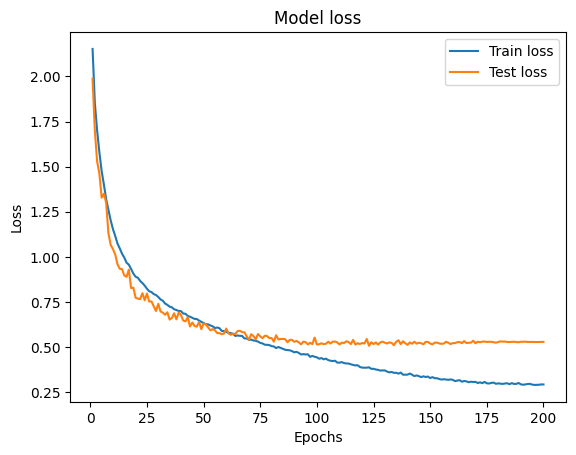

In [ ]:
plt.plot(history['train_loss'], label="Train loss")
plt.plot(history['test_loss'], label="Test loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Model loss")
plt.savefig("loss.png")

Model accuracy

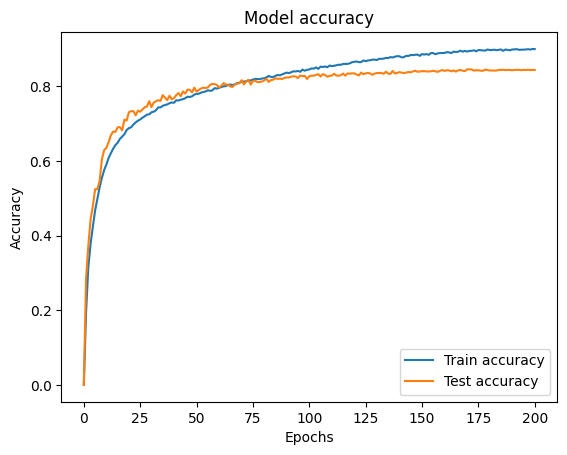

In [ ]:
plt.plot(history['train_acc'], label="Train accuracy")
plt.plot(history['test_acc'], label="Test accuracy")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model accuracy")
plt.savefig("acc.png")

In [ ]:
with open('1.txt', 'w') as f:
    f.write(f"{max(history['train_acc'])}, {min(history['train_loss'])}\n")
    f.write(f"{max(history['test_acc'])}, {min(history['test_loss'])}")

In [ ]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[[[ 0.0035,  0.0602,  0.0245, -0.0117, -0.0160],
          [-0.0160, -0.0846,  0.0157, -0.0279,  0.0319],
          [ 0.0760, -0.0843,  0.0813, -0.1069, -0.0071],
          [ 0.0485, -0.0808, -0.0494, -0.0343,  0.0038],
          [-0.0062,  0.0394,  0.0026,  0.1137, -0.0020]],

         [[-0.0644, -0.0815,  0.0184,  0.0397, -0.0540],
          [-0.0880,  0.0603,  0.0944, -0.0418,  0.0480],
          [ 0.0681,  0.0158,  0.0465, -0.1324, -0.0638],
          [-0.0637,  0.0098,  0.1156,  0.0471,  0.0320],
          [ 0.0452, -0.0603,  0.0218,  0.0754,  0.0205]],

         [[ 0.0597,  0.0753,  0.0602,  0.0512, -0.0207],
          [-0.0345,  0.0332,  0.1488, -0.0486,  0.0700],
          [ 0.1209,  0.0121,  0.1429, -0.1206, -0.1118],
          [ 0.1474,  0.0371,  0.0969, -0.0932, -0.1251],
          [ 0.0441,  0.0960, -0.1371, -0.0499, -0.1471]]],


        [[[-0.0375, -0.1029, -0.0091, -0.0822,  0.0174],
          [ 0.0567,  0.0233, -0.0166,  0.0263,  0.0690],
 